In [1]:
#Importing relevant libraries

import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import numpy as np

import math

#anthrax_data = genfromtxt('anthrax.csv', delimiter=',') #in the form of [t, S, I, A, C]

torch.manual_seed(1234) #set seed (optional)
     

In [2]:
#creating a list for each compartments of the model that will Load data
V1_dat = [] 
V2_dat = []
V3_dat = []
V4_dat = []
H1_dat = []
H2_dat = []
H3_dat = []

timesteps = []
pop_dat = []


In [3]:
#importing the data
data_frame = pd.read_csv('Anthrax_Fract_data.csv')  
d1 = data_frame['H1'] #T x 1 array 
d2 = data_frame['H2'] #T x 1 array
d3 = data_frame['H3'] #T x 1 array
d4 = data_frame['V1'] #T x 1 array
d5 = data_frame['V2']
d6 = data_frame['V3']
d7 = data_frame['V4']
d8 = data_frame['Tspan']

In [4]:
#Sample of data to work with
for item in range(len(d8)):
    if item%15 == 0:
        H1_dat.append(d1[item])
        H2_dat.append(d2[item])
        H3_dat.append(d3[item]) 
        V1_dat.append(d4[item])
        V2_dat.append(d5[item])
        V3_dat.append(d6[item])
        V4_dat.append(d7[item])
        timesteps.append(d8[item])
print(len(timesteps))

17


In [5]:

H1_dat

len(list(range(50, 63)))
#timesteps
#data_frame

13

In [6]:
len(list(range(48, 65)))

17

In [7]:
#Definding a class 

#%%time

PATH = 'Anthrax simulation' 

class DINN(nn.Module):
    def __init__(self, t, V1_dat, V2_dat, V3_dat, V4_dat, H1_dat, H2_dat, H3_dat): # remember that the data was saved as [t,S,I,D,R]
        super(DINN, self).__init__()
        
       
        #for the time steps, we need to convert them to a tensor, a float, and eventually to reshape it so it can be used as a batch
        self.t = torch.tensor(t, requires_grad=True)
        self.tt = torch.tensor(list(range(48, 65)))
        self.t_float = self.t.float()
        self.tt_float = self.tt.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.tt_batch = torch.reshape(self.tt_float, (len(self.tt),1)) #reshape for batch 

        #for the compartments we just need to convert them into tensors
        self.H1 = torch.tensor(H1_dat)
        self.H2 = torch.tensor(H2_dat)
        self.H3 = torch.tensor(H3_dat)
        self.V1 = torch.tensor(V1_dat)
        self.V2 = torch.tensor(V2_dat)
        self.V3 = torch.tensor(V3_dat)
        self.V4 = torch.tensor(V4_dat)
       
        #Initial conditions
        self.N_h = torch.tensor(H1_dat[0] + H2_dat[0] + H3_dat[0])
        self.H10 = torch.tensor(H1_dat[0])
        self.H20 = torch.tensor(H2_dat[0])
        self.H30 = torch.tensor(H3_dat[0])
        
        self.N_v = torch.tensor(V1_dat[0] + V2_dat[0] + V3_dat[0] + V4_dat[0])
        self.V10 = torch.tensor(V1_dat[0])
        self.V20 = torch.tensor(V2_dat[0])
        self.V30 = torch.tensor(V3_dat[0])
        self.V40 = torch.tensor(V4_dat[0])
       
        self.losses = [] # here I saved the model's losses per epoch 
        self.save = 2
        
        #learnable parameters
    
        #Disease parameters
        self.delta_h_tilda = torch.tensor(0.2, dtype=torch.float32,requires_grad=False) 
        self.delta_v_tilda = torch.tensor(0.005, dtype=torch.float32,requires_grad=False) 
        self.lambd_h_tilda = torch.tensor(0.00005, dtype=torch.float32,requires_grad=False)  
        self.lambd_v_tilda = torch.tensor(0.00005, dtype=torch.float32,requires_grad=False) 
        self.tita_tilda = torch.tensor(0.00005, dtype=torch.float32,requires_grad=False) 
        self.beta_h_tilda = torch.tensor(0.006, dtype=torch.float32,requires_grad=False)  
        self.beta_v_tilda = torch.tensor(0.00005, dtype=torch.float32,requires_grad=False)  
        self.mu_h_tilda = torch.tensor(0.0001, dtype=torch.float32,requires_grad=False) 
        self.mu_v_tilda = torch.tensor(0.0004, dtype=torch.float32,requires_grad=False) 
        self.alpha_h_tilda = torch.tensor(0.2, dtype=torch.float32,requires_grad=False) 
        self.alpha_v_tilda = torch.tensor(0.45, dtype=torch.float32,requires_grad=False) 
        self.phi_h_tilda = torch.tensor(0.75, dtype=torch.float32,requires_grad=False)  
        self.phi_v_tilda = torch.tensor(0.0025, dtype=torch.float32,requires_grad=False) 
        self.sigma_tilda = torch.tensor(0.002, dtype=torch.float32,requires_grad=False) 
        self.rho_tilda = torch.tensor(0.0001, dtype=torch.float32,requires_grad=False) 
        
        #Disease parameters history
        self.delta_h_history = []
        self.delta_v_history = []
        self.lambd_h_history = []
        self.lambd_v_history = []
        self.tita_history = []
        self.beta_h_history = [] 
        self.beta_v_history = []
        self.mu_h_history = []
        self.mu_v_history = []
        self.alpha_h_history = [] 
        self.alpha_v_history = [] 
        self.phi_h_history = []
        self.phi_v_history = []
        self.sigma_history = []
        self.rho_history = []
        
        
        
        
        #Fractional parameters
        self.x1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.x2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.x3_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.x4_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.x5_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.x6_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.x7_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True))
        
        #Fractional parameters history
        self.x1_history = []
        self.x2_history = []
        self.x3_history = []
        self.x4_history = []
        self.x5_history = []
        self.x6_history = []
        self.x7_history = []
        
        
        #Prediction history
        self.H1_pred_hist = []
        self.H2_pred_hist = []
        self.H3_pred_hist = []
        self.V1_pred_hist = []
        self.V2_pred_hist = []
        self.V3_pred_hist = []
        self.V4_pred_hist = []
        
        
        #Advanced history
        self.H1_adv_hist = []
        self.H2_adv_hist = []
        self.H3_adv_hist = []
        self.V1_adv_hist = []
        self.V2_adv_hist = []
        self.V3_adv_hist = []
        self.V4_adv_hist = []
       
        
        
        #matrices (x7 for V1, V2, V3, V4, H1, H2, H3) for the gradients
        self.m1 = torch.zeros((len(self.t), 7)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 7)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 7)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 7)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 7)); self.m5[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 7)); self.m6[:, 5] = 1
        self.m7 = torch.zeros((len(self.t), 7)); self.m7[:, 6] = 1
        
        #values for norm
        self.H1_max = max(self.H1)
        self.H2_max = max(self.H2)
        self.H3_max = max(self.H3)
        self.V1_max = max(self.V1)
        self.V2_max = max(self.V2)
        self.V3_max = max(self.V3)
        self.V4_max = max(self.V4)
        
        self.H1_min = min(self.H1)
        self.H2_min = min(self.H2)
        self.H3_min = min(self.H3)
        self.V1_min = min(self.V1)
        self.V2_min = min(self.V2)
        self.V3_min = min(self.V3)
        self.V4_min = min(self.V4)
        
        
        #normalize 
        self.H1_hat = (self.H1 - self.H1_min)/(self.H1_max - self.H1_min)
        self.H2_hat = (self.H2 - self.H2_min)/(self.H2_max - self.H2_min)
        self.H3_hat = (self.H3 - self.H3_min)/(self.H3_max - self.H3_min)
        self.V1_hat = (self.V1 - self.V1_min)/(self.V1_max - self.V1_min)
        self.V2_hat = (self.V2 - self.V2_min)/(self.V2_max - self.V2_min)
        self.V3_hat = (self.V3 - self.V3_min)/(self.V3_max - self.V3_min)
        self.V4_hat = (self.V4 - self.V4_min)/(self.V4_max - self.V4_min)
        
        
        #NN
        self.net_anthrax = self.Net_anthrax()
        self.params = list(self.net_anthrax.parameters())
        self.params.extend(list([self.x1_tilda, self.x2_tilda, self.x3_tilda, 
                                 self.x4_tilda, self.x5_tilda, self.x6_tilda, self.x7_tilda, 
                                 ]))
        '''
        self.params.extend(list([self.x1_tilda, self.x2_tilda, self.x3_tilda, self.x4_tilda, self.x5_tilda, self.x6_tilda, self.x7_tilda, 
                                 self.delta_h_tilda, self.delta_v_tilda, self.lambd_h_tilda, self.lambd_v_tilda, self.tita_tilda,
                                 self.beta_h_tilda, self.beta_v_tilda, self.mu_h_tilda, self.mu_v_tilda, self.alpha_h_tilda,
                                 self.alpha_v_tilda, self.phi_h_tilda, self.phi_v_tilda, self.sigma_tilda, self.rho_tilda]))
        '''
    
    #force disease parameters to be in a range

    @property
    def delta_h(self):
        #return torch.clamp(torch.tanh(self.delta_h_tilda)*0.005, min=0, max=1)
        return self.delta_h_tilda
    @property
    def delta_v(self):
        #return torch.clamp(torch.tanh(self.delta_v_tilda)*0.005, min=0, max=1)
        return self.delta_v_tilda
        
    @property
    def lambd_h(self):
        #return torch.clamp(torch.tanh(self.lambd_h_tilda)*0.05, min=0, max=1)
        return self.lambd_h_tilda
        
    @property
    def lambd_v(self):
        #return torch.tanh(self.lambd_v_tilda) * 0.0000000024 + 0.098
        #return torch.clamp(torch.tanh(self.lambd_v_tilda)*0.0005, min=0, max=1)
        return self.lambd_v_tilda
        
    @property
    def tita(self):
        #return torch.tanh(self.tita_tilda) * 0.0000000021 + 0.08 
        #return torch.clamp(torch.tanh(self.tita_tilda)*0.005, min=0, max=1)
        return self.tita_tilda
        
    @property
    def beta_h(self):
        #return torch.tanh(self.beta_h_tilda) * 0.00000002 + 0.09
        #return torch.clamp(torch.tanh(self.beta_h_tilda)*0.05, min=0, max=1)
        return self.beta_h_tilda
        
    @property
    def beta_v(self):
        #return torch.tanh(self.beta_v_tilda) * 0.000000006 + 0.08
        #return torch.clamp(torch.tanh(self.beta_v_tilda)*0.005, min=0, max=1)
        return self.beta_v_tilda
    
    @property
    def mu_h(self):
        #return torch.tanh(self.mu_h_tilda) * 0.0000000011 + 0.009
        #return torch.clamp(torch.tanh(self.mu_h_tilda)*0.005, min=0, max=1)
        return self.mu_h_tilda
    
    @property
    def mu_v(self):
        #return torch.tanh(self.mu_v_tilda) * 0.0000000008 + 0.01
        #return torch.clamp(torch.tanh(self.mu_v_tilda)*0.00005, min=0, max=1)
        return self.mu_v_tilda
        
    @property
    def alpha_h(self):
        #return torch.tanh(self.alpha_h_tilda)* 0.0000000006 + 0.008
        #return torch.clamp(torch.tanh(self.alpha_h_tilda)*0.005, min=0, max=1)
        return self.alpha_h_tilda
        
    @property
    def alpha_v(self):
        #return torch.tanh(self.alpha_v_tilda) * 0.000000024 + 0.01
        #return torch.clamp(torch.tanh(self.alpha_v_tilda)*0.005, min=0, max=1)
        return self.alpha_v_tilda
        
    @property
    def phi_h(self):
        #return torch.tanh(self.phi_h_tilda) * 0.0000000002 + 0.009
        #return torch.clamp(torch.tanh(self.phi_h_tilda)*0.05, min=0, max=1)
        return self.phi_h_tilda
        
    @property
    def phi_v(self):
        #return torch.tanh(self.phi_v_tilda) * 0.00000654 + 0.008
        #return torch.clamp(torch.tanh(self.phi_v_tilda)*0.05, min=0, max=1)
        return self.phi_v_tilda
        
    @property
    def sigma(self):
        #return torch.tanh(self.sigma_tilda) * 0.000000002 +  0.01
        #return torch.clamp(torch.tanh(self.sigma_tilda)*0.0005, min=0, max=1)
        return self.sigma_tilda
    
    @property
    def rho(self):
        #return torch.tanh(self.rho_tilda) * 0.00000004448 + 0.098
        #return torch.clamp(torch.tanh(self.rho_tilda)*0.005, min=0, max=1)
        return self.rho_tilda
    
   
    #force fractional parameters to be in a range
    @property
    def x1(self):
        #return torch.clamp(torch.tanh(self.x1_tilda)*0.7 + 0.3, min=0.7, max=1)
        return torch.tanh(self.x1_tilda)* 0.01+ 0.99
    
    @property
    def x2(self):
        #return torch.clamp(torch.tanh(self.x2_tilda)*0.7 + 0.3, min=0.7, max=1)
        return torch.tanh(self.x2_tilda)* 0.01+ 0.99
    
    @property
    def x3(self):
        #return torch.clamp(torch.tanh(self.x3_tilda)*0.7 + 0.3, min=0.7, max=1)
        return torch.tanh(self.x3_tilda)* 0.01+ 0.99
    
    @property
    def x4(self):
        #return torch.clamp(torch.tanh(self.x4_tilda)*0.7 + 0.3, min=0.7, max=1)
        return torch.tanh(self.x4_tilda)* 0.01+ 0.99
    
    @property
    def x5(self):
        #return torch.clamp(torch.tanh(self.x5_tilda)*0.7 + 0.3, min=0.7, max=1)
        return torch.tanh(self.x5_tilda)* 0.01+ 0.99
    
    @property
    def x6(self):
        #return torch.clamp(torch.tanh(self.x6_tilda)*0.7 + 0.3, min=0.7, max=1)
        return torch.tanh(self.x6_tilda)* 0.01+ 0.99
    @property
    def x7(self):
        #return torch.clamp(torch.tanh(self.x7_tilda)*0.7 + 0.3, min=0.7, max=1)
        return torch.tanh(self.x7_tilda)* 0.01+ 0.99
    
    
   
    #nets
    class Net_anthrax(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_anthrax, self).__init__()
            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 7) #outputs V1, V2, V3, V4, H1, H2, H3

        def forward(self, t_batch):
            anthrax=F.relu(self.fc1(t_batch))
            anthrax=F.relu(self.fc2(anthrax))
            anthrax=F.relu(self.fc3(anthrax))
            anthrax=F.relu(self.fc4(anthrax))
            anthrax=F.relu(self.fc5(anthrax))
            anthrax=F.relu(self.fc6(anthrax))
            anthrax=F.relu(self.fc7(anthrax))
            anthrax=F.relu(self.fc8(anthrax))
            anthrax=self.out(anthrax)
            return anthrax    
    
    
    def net_f(self, t_batch):       

        anthrax_hat = self.net_anthrax(t_batch)

        V1_hat, V2_hat, V3_hat, V4_hat, H1_hat, H2_hat, H3_hat = anthrax_hat[:,0], anthrax_hat[:,1], anthrax_hat[:,2], anthrax_hat[:,3], anthrax_hat[:,4], anthrax_hat[:,5], anthrax_hat[:,6]
        

        #V1_hat
        anthrax_hat.backward(self.m1, retain_graph=True)
        V1_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #V2_hat
        anthrax_hat.backward(self.m2, retain_graph=True)
        V2_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #V3_hat
        anthrax_hat.backward(self.m3, retain_graph=True)
        V3_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #V4_hat
        anthrax_hat.backward(self.m4, retain_graph=True)
        V4_hat_t = self.t.grad.clone()
        self.t.grad.zero_()
        
        #H1_hat
        anthrax_hat.backward(self.m5, retain_graph=True)
        H1_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #H2_hat
        anthrax_hat.backward(self.m6, retain_graph=True)
        H2_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #H3_hat
        anthrax_hat.backward(self.m7, retain_graph=True)
        H3_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        H1 = self.H1_min + (self.H1_max - self.H1_min) * H1_hat
        H2 = self.H2_min + (self.H2_max - self.H2_min) * H2_hat
        H3 = self.H3_min + (self.H3_max - self.H3_min) * H3_hat
     
        V1 = self.V1_min + (self.V1_max - self.V1_min) * V1_hat
        V2 = self.V2_min + (self.V2_max - self.V2_min) * V2_hat
        V3 = self.V3_min + (self.V3_max - self.V3_min) * V3_hat
        V4 = self.V4_min + (self.V4_max - self.V4_min) * V4_hat
        
        #equations
        f1_hat = H1_hat_t - (((self.x1-1)/self.x1)*(H1-self.H10) + (self.delta_h * self.N_h - (self.lambd_h * H1 * H2 + self.tita * H1 * V2)/self.N_h + self.beta_h * H3 - self.mu_h * H1)/self.x1) / (self.H1_max - self.H1_min) 
        f2_hat = H2_hat_t - (((self.x2-1)/self.x2)*(H2-self.H20) + ((self.lambd_h * H1 * H2 + self.tita * H1 * V2)/self.N_h - (self.mu_h + self.alpha_h + self.phi_h) * H2)/self.x2) / (self.H2_max - self.H2_min) 
        f3_hat = H3_hat_t - (((self.x3-1)/self.x3)*(H3-self.H30) + (self.phi_h * H2  - (self.mu_h + self.beta_h) * H3)/self.x3) / (self.H3_max - self.H3_min) 
        f4_hat = V1_hat_t - (((self.x4-1)/self.x4)*(V1-self.V10) + (self.delta_v * self.N_v - (self.lambd_v * V1 * V2)/self.N_v - (self.mu_v + self.rho) * V1 + self.beta_v * V3 + self.sigma * V4)/self.x4) / (self.V1_max - self.V1_min) 
        f5_hat = V2_hat_t - (((self.x5-1)/self.x5)*(V2-self.V20) + ((self.lambd_v * V1 * V2)/self.N_v - (self.mu_v + self.phi_v + self.alpha_v) * V2) /self.x5) / (self.V2_max - self.V2_min) 
        f6_hat = V3_hat_t - (((self.x6-1)/self.x6)*(V3-self.V30) + (self.phi_v * V2 - (self.mu_v + self.beta_v) * V3)/self.x6) / (self.V3_max - self.V3_min) 
        f7_hat = V4_hat_t - (((self.x7-1)/self.x7)*(V4-self.V40) + (self.rho * V1 - self.sigma * V4)/self.x7) / (self.V4_max - self.V4_min) 
        
        return f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, f6_hat, f7_hat, V1_hat, V2_hat, V3_hat, V4_hat, H1_hat, H2_hat, H3_hat
    
    
    def load(self):
        # Load checkpoint
        try:
            checkpoint = torch.load(PATH + str(self.save)+'.pt') 
            print('\nloading pre-trained model...')
            self.load_state_dict(checkpoint['model'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.scheduler.load_state_dict(checkpoint['scheduler'])
            epoch = checkpoint['epoch']
            loss = checkpoint['loss']
            self.losses = checkpoint['losses']
            print('loaded previous loss: ', loss)
        except RuntimeError :
            print('changed the architecture, ignore')
            pass
        except FileNotFoundError:
            pass
    
    def train(self, n_epochs):
        
      #try loading
      #self.load()

      #train
        print('\nstarting training...\n')
      
        for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
            V1_pred_list = []
            V2_pred_list = []
            V3_pred_list = []
            V4_pred_list = []
            H1_pred_list = []
            H2_pred_list = []
            H3_pred_list = []
           
        #Advanced
            V1_Adv_list = []
            V2_Adv_list = []
            V3_Adv_list = []
            V4_Adv_list = []
            H1_Adv_list = []
            H2_Adv_list = []
            H3_Adv_list = []


            f1, f2, f3, f4, f5, f6, f7, V1_pred, V2_pred, V3_pred, V4_pred, H1_pred, H2_pred, H3_pred = self.net_f(self.t_batch)
            _,_,_,_,_,_,_, V1_advan, V2_advan, V3_advan, V4_advan, H1_advan, H2_advan, H3_advan = self.net_f(self.tt_batch)
            self.optimizer.zero_grad()

           
        
            loss = (
                torch.mean(torch.square(self.V1_hat - V1_pred)) + torch.mean(torch.square(self.V2_hat - V2_pred)) + 
                torch.mean(torch.square(self.V3_hat - V3_pred)) + torch.mean(torch.square(self.V4_hat - V4_pred)) +
                torch.mean(torch.square(self.H1_hat - H1_pred)) + torch.mean(torch.square(self.H2_hat - H2_pred)) + 
                torch.mean(torch.square(self.H3_hat - H3_pred)) + torch.mean(torch.square(f1)) + torch.mean(torch.square(f2)) +
                torch.mean(torch.square(f3)) + torch.mean(torch.square(f4)) + torch.mean(torch.square(f5)) + torch.mean(torch.square(f6)) + torch.mean(torch.square(f7))
               )

            loss.backward()
        
            self.optimizer.step()
            self.scheduler.step() 
        #self.scheduler.step(loss) 
            H1_pred_list.append(self.H1_min + (self.H1_max - self.H1_min) * H1_pred)
            H2_pred_list.append(self.H2_min + (self.H2_max - self.H2_min) * H2_pred)
            H3_pred_list.append(self.H3_min + (self.H3_max - self.H3_min) * H3_pred)
            V1_pred_list.append(self.V1_min + (self.V1_max - self.V1_min) * V1_pred)
            V2_pred_list.append(self.V2_min + (self.V2_max - self.V2_min) * V2_pred)
            V3_pred_list.append(self.V3_min + (self.V3_max - self.V3_min) * V3_pred)
            V4_pred_list.append(self.V4_min + (self.V4_max - self.V4_min) * V4_pred)
           
            
            H1_Adv_list.append(self.H1_min + (self.H1_max - self.H1_min) * H1_advan)
            H2_Adv_list.append(self.H2_min + (self.H2_max - self.H2_min) * H2_advan)
            H3_Adv_list.append(self.H3_min + (self.H3_max - self.H3_min) * H3_advan)
            V1_Adv_list.append(self.V1_min + (self.V1_max - self.V1_min) * V1_advan)
            V2_Adv_list.append(self.V2_min + (self.V2_max - self.V2_min) * V2_advan)
            V3_Adv_list.append(self.V3_min + (self.V3_max - self.V3_min) * V3_advan)
            V4_Adv_list.append(self.V4_min + (self.V4_max - self.V4_min) * V4_advan)
            
            
            self.x1_history.append(self.x1)
            self.x2_history.append(self.x2)
            self.x3_history.append(self.x3)
            self.x4_history.append(self.x4)
            self.x5_history.append(self.x5)
            self.x6_history.append(self.x6)
            self.x7_history.append(self.x7)
        
            self.delta_h_history.append(self.delta_h)
            self.delta_h_history.append(self.delta_v)
            self.lambd_h_history.append(self.lambd_h)
            self.lambd_h_history.append(self.lambd_v)
            self.tita_history.append(self.tita)
            self.beta_h_history.append(self.beta_h)
            self.beta_v_history.append(self.beta_v)
            self.mu_h_history.append(self.mu_h)
            self.mu_v_history.append(self.mu_v)
            self.alpha_h_history.append(self.alpha_h)
            self.alpha_v_history.append(self.alpha_v)
            self.phi_h_history.append(self.phi_h)
            self.phi_v_history.append(self.phi_v)
            self.sigma_history.append(self.sigma)
            self.rho_history.append(self.rho)
        
            
            
            
            self.losses.append(loss.item())
            

            if epoch % 1000 == 0:
                
                print('\nEpoch ', epoch)
                #loss + model parameters update
                self.V1_pred_hist.append(self.V1_min + (self.V1_max - self.V1_min) * V1_pred)
                self.V2_pred_hist.append(self.V2_min + (self.V2_max - self.V2_min) * V2_pred)
                self.V3_pred_hist.append(self.V3_min + (self.V3_max - self.V3_min) * V3_pred)
                self.V4_pred_hist.append(self.V4_min + (self.V4_max - self.V4_min) * V4_pred)
                self.H1_pred_hist.append(self.H1_min + (self.H1_max - self.H1_min) * H1_pred)
                self.H2_pred_hist.append(self.H2_min + (self.H2_max - self.H2_min) * H2_pred)
                self.H3_pred_hist.append(self.H3_min + (self.H3_max - self.H3_min) * H3_pred)
            
                self.V1_adv_hist.append(self.V1_min + (self.V1_max - self.V1_min) * V1_advan)
                self.V2_adv_hist.append(self.V2_min + (self.V2_max - self.V2_min) * V2_advan)
                self.V3_adv_hist.append(self.V3_min + (self.V3_max - self.V3_min) * V3_advan)
                self.V4_adv_hist.append(self.V4_min + (self.V4_max - self.V4_min) * V4_advan)
                self.H1_adv_hist.append(self.H1_min + (self.H1_max - self.H1_min) * H1_advan)
                self.H2_adv_hist.append(self.H2_min + (self.H2_max - self.H2_min) * H2_advan)
                self.H3_adv_hist.append(self.H3_min + (self.H3_max - self.H3_min) * H3_advan)
            if epoch % 4000 == 0:
                
            #checkpoint save every 100 epochs if the loss is lower
                print('\nSaving model... Loss is: ', loss)
                torch.save({'epoch': epoch,'model': self.state_dict(),'optimizer_state_dict': self.optimizer.state_dict(),
                            'scheduler': self.scheduler.state_dict(),'loss': loss,'losses': self.losses}, PATH + str(self.save)+'.pt')
                if self.save % 2 > 0: #its on 3
                    self.save = 2 #change to 2
                else: #its on 2
                    self.save = 3 #change to 3

                print('epoch: ', epoch)
                print('#################################')
        
        
                #plot
                plt.plot(self.losses, color = 'red')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
    
        return V1_pred_list, V2_pred_list, V3_pred_list, V4_pred_list, H1_pred_list, H2_pred_list, H3_pred_list, V1_Adv_list, V2_Adv_list, V3_Adv_list, V4_Adv_list, H1_Adv_list, H2_Adv_list, H3_Adv_list

    


starting training...


Epoch  0

Saving model... Loss is:  tensor(3.4717, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  0
#################################

Epoch  1000

Epoch  2000

Epoch  3000

Epoch  4000

Saving model... Loss is:  tensor(0.4097, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  4000
#################################

Epoch  5000

Epoch  6000

Epoch  7000

Epoch  8000

Saving model... Loss is:  tensor(0.1924, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  8000
#################################

Epoch  9000

Epoch  10000

Epoch  11000

Epoch  12000

Saving model... Loss is:  tensor(0.0784, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  12000
#################################

Epoch  13000

Epoch  14000

Epoch  15000

Epoch  16000

Saving model... Loss is:  tensor(0.0652, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  16000
#################################

Epoch  17000

Epoch  18000

Epoch  19000

Epoch  20000

Saving model... Loss is:  

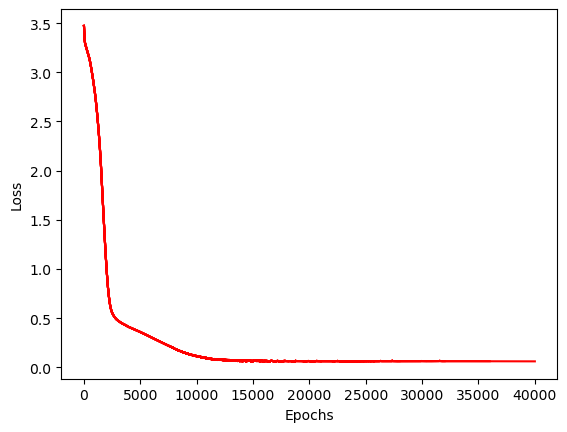

In [8]:
%%time
#timesteps, V2_dat, V3_dat, V4_dat, H1_dat, H2_dat, H3_dat, pop_dat
#anthrax_data[7], anthrax_data[0], anthrax_data[1], anthrax_data[2], anthrax_data[3],anthrax_data[4], anthrax_data[5], anthrax_data[6]

dinn = DINN(timesteps, V1_dat, V2_dat, V3_dat, V4_dat, H1_dat, H2_dat, H3_dat)

learning_rate = 1e-3
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-5, max_lr=1e-2, step_size_up=1000, mode="exp_range", gamma=0.95, cycle_momentum=False)

dinn.scheduler = scheduler

try: 
    V1_pred_list, V2_pred_list, V3_pred_list, V4_pred_list, H1_pred_list, H2_pred_list, H3_pred_list, V1_Adv_list, V2_Adv_list, V3_Adv_list, V4_Adv_list, H1_Adv_list, H2_Adv_list, H3_Adv_list = dinn.train(41000) #train
except EOFError:
    if dinn.save == 2:
        dinn.save = 3
        V1_pred_list, V2_pred_list, V3_pred_list, V4_pred_list, H1_pred_list, H2_pred_list, H3_pred_list, V1_Adv_list, V2_Adv_list, V3_Adv_list, V4_Adv_list, H1_Adv_list, H2_Adv_list, H3_Adv_list = dinn.train(41000) #train
    elif dinn.save == 3:
        dinn.save = 2
        V1_pred_list, V2_pred_list, V3_pred_list, V4_pred_list, H1_pred_list, H2_pred_list, H3_pred_list, V1_Adv_list, V2_Adv_list, V3_Adv_list, V4_Adv_list, H1_Adv_list, H2_Adv_list, H3_Adv_list = dinn.train(41000) #train

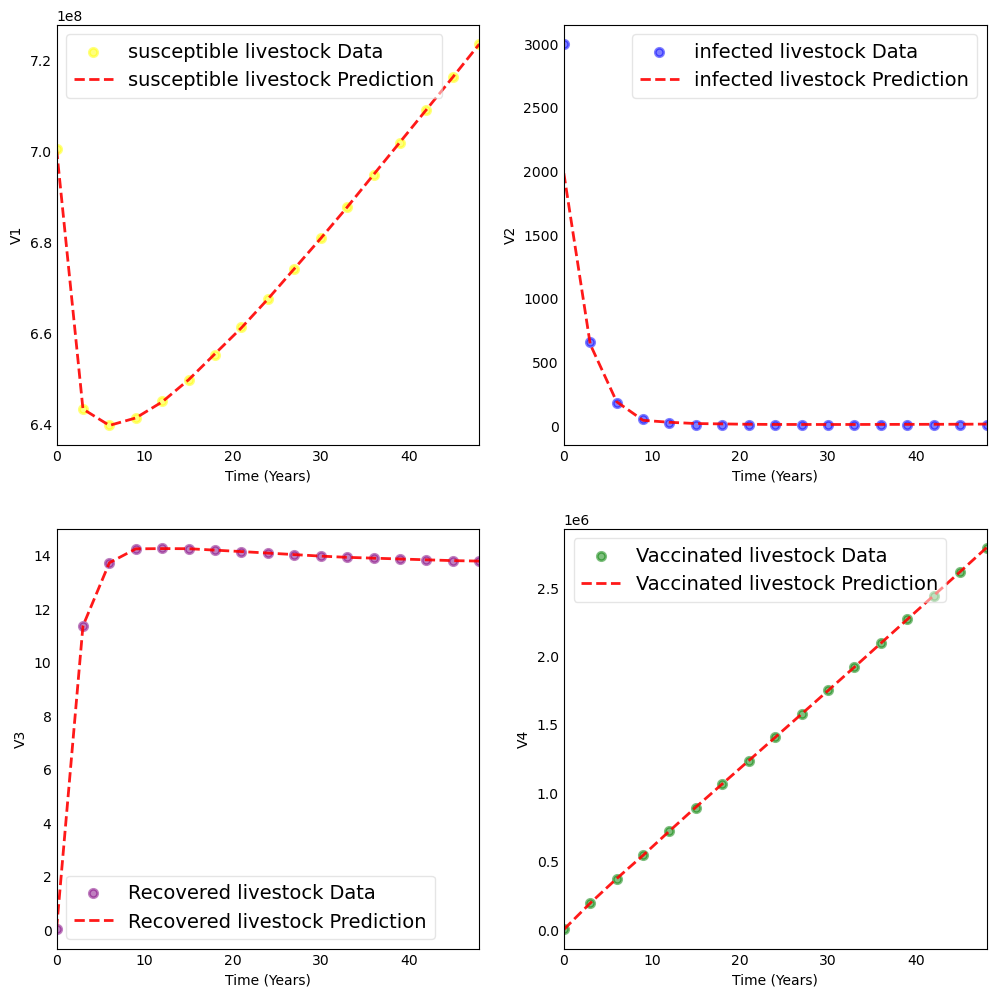

In [9]:
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

fig, ax = plt.subplots(2, 2, figsize = (12,12))


ax[0, 0].set_facecolor('xkcd:white')
ax[1, 0].set_facecolor('xkcd:white')
ax[0, 1].set_facecolor('xkcd:white')
ax[1, 1].set_facecolor('xkcd:white')


ax[0, 0].scatter(timesteps, V1_dat, c = 'yellow', alpha=0.5, lw=2, label='susceptible livestock Data')
#ax[0, 0].scatter(timesteps[28:], Susceptible[28:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 0].plot(timesteps, V1_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='susceptible livestock Prediction', linestyle='dashed')


ax[0, 0].set_xlabel('Time (Years)',size = 10)
ax[0, 0].set_ylabel('V1',size = 10)
ax[0, 0].yaxis.set_tick_params(length=0)
ax[0, 0].xaxis.set_tick_params(length=0)
ax[0, 0].set_xlim(timesteps[0],timesteps[-1] )
# ax[0, 0].grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax[0, 0].legend(prop={'size':14})
legend.get_frame().set_alpha(0.5)
#for spine in ('top', 'right', 'bottom', 'left'):
 #   ax[0, 0].spines[spine].set_visible(False)
############################################################


ax[1, 0].scatter(timesteps, V3_dat, c = 'purple', alpha=0.5, lw=2, label='Recovered livestock Data')
#ax[1, 0].scatter(timesteps[28:], Susceptible[28:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 0].plot(timesteps, V3_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Recovered livestock Prediction', linestyle='dashed')

ax[1, 0].set_xlabel('Time (Years)',size = 10)
ax[1, 0].set_ylabel('V3',size = 10)
ax[1, 0].yaxis.set_tick_params(length=0)
ax[1, 0].xaxis.set_tick_params(length=0)
ax[1, 0].set_xlim(timesteps[0],timesteps[-1] )
# ax[1, 0].grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax[1, 0].legend(prop={'size':14})
legend.get_frame().set_alpha(0.5)
#for spine in ('top', 'right', 'bottom', 'left'):
 #   ax[1, 0].spines[spine].set_visible(False)
############################################################


ax[0, 1].scatter(timesteps, V2_dat, c = 'blue', alpha=0.5, lw=2, label='infected livestock Data')
#ax[0, 1].scatter(timesteps[28:], Susceptible[28:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 1].plot(timesteps, V2_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='infected livestock Prediction', linestyle='dashed')

ax[0, 1].set_xlabel('Time (Years)',size = 10)
ax[0, 1].set_ylabel('V2',size = 10)
ax[0, 1].yaxis.set_tick_params(length=0)
ax[0, 1].xaxis.set_tick_params(length=0)
ax[0, 1].set_xlim(timesteps[0] ,timesteps[-1] )
# ax[0, 1].grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax[0, 1].legend(prop={'size':14})
legend.get_frame().set_alpha(0.5)
#for spine in ('top', 'right', 'bottom', 'left'):
 #   ax[0, 1].spines[spine].set_visible(False)
############################################################

ax[1, 1].scatter(timesteps, V4_dat, c = 'green', alpha=0.5, lw=2, label='Vaccinated livestock Data')
#ax[1, 1].scatter(timesteps[28:], Susceptible[28:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 1].plot(timesteps, V4_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Vaccinated livestock Prediction', linestyle='dashed')


ax[1, 1].set_xlabel('Time (Years)',size = 10)
ax[1, 1].set_ylabel('V4',size = 10)
ax[1, 1].yaxis.set_tick_params(length=0)
ax[1, 1].xaxis.set_tick_params(length=0)
ax[1, 1].set_xlim(timesteps[0],timesteps[-1] )

# ax[1, 1].grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax[1,1].legend(prop={'size':14})
legend.get_frame().set_alpha(0.5)
#for spine in ('top', 'right', 'bottom', 'left'):
 #   ax[1,1].spines[spine].set_visible(False)
############################################################
# plt.savefig('covid_real_data_cumulative_cases.pdf')
#plt.savefig('Fitted.pdf', dpi=300)
#plt.savefig('Fitted.png', dpi=300)

plt.show()

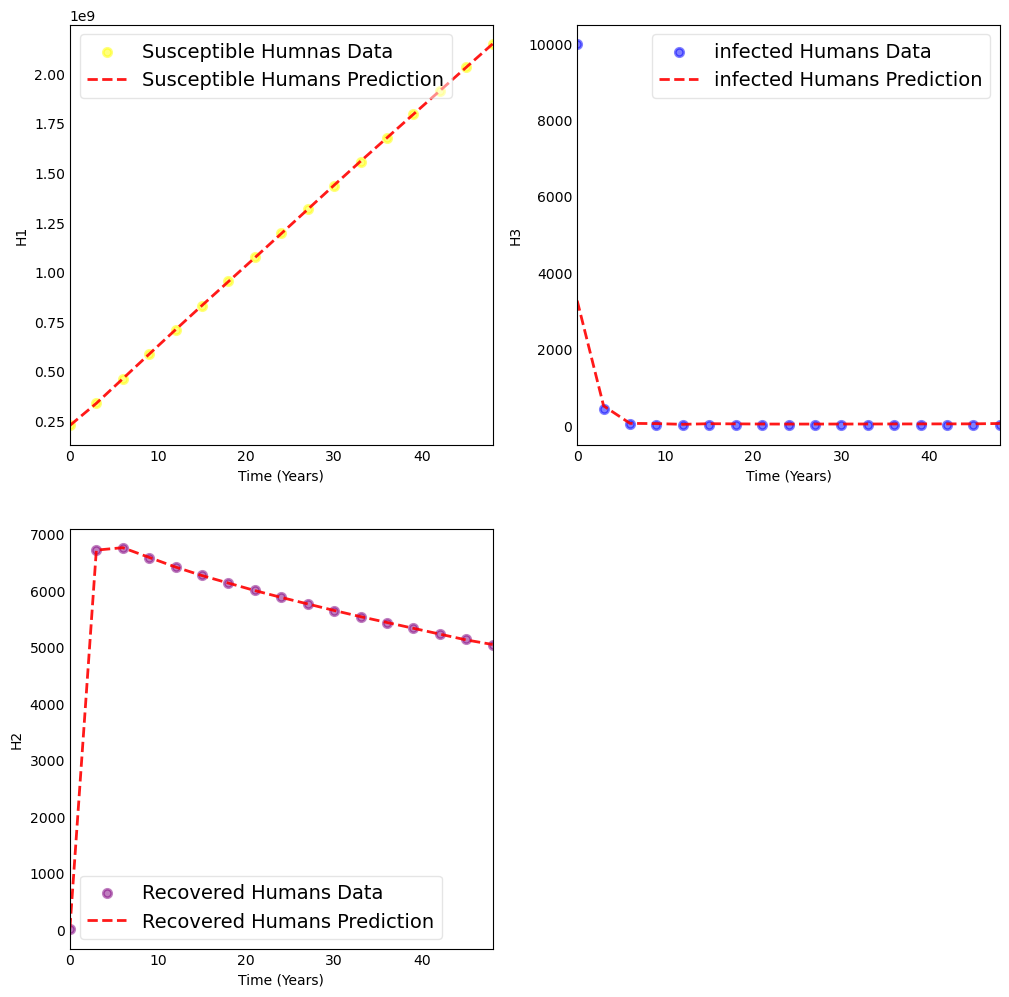

In [10]:
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

fig, ax = plt.subplots(2, 2, figsize = (12,12))


ax[0, 0].set_facecolor('xkcd:white')
ax[1, 0].set_facecolor('xkcd:white')
ax[0, 1].set_facecolor('xkcd:white')




ax[0, 0].scatter(timesteps, H1_dat, c = 'yellow', alpha=0.5, lw=2, label='Susceptible Humnas Data')
#ax[0, 0].scatter(timesteps[28:], Susceptible[28:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 0].plot(timesteps, H1_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Susceptible Humans Prediction', linestyle='dashed')


ax[0, 0].set_xlabel('Time (Years)',size = 10)
ax[0, 0].set_ylabel('H1',size = 10)
ax[0, 0].yaxis.set_tick_params(length=0)
ax[0, 0].xaxis.set_tick_params(length=0)
ax[0, 0].set_xlim(timesteps[0],timesteps[-1] )
# ax[0, 0].grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax[0, 0].legend(prop={'size':14})
legend.get_frame().set_alpha(0.5)
#for spine in ('top', 'right', 'bottom', 'left'):
 #   ax[0, 0].spines[spine].set_visible(False)
############################################################


ax[1, 0].scatter(timesteps, H3_dat, c = 'purple', alpha=0.5, lw=2, label='Recovered Humans Data')
#ax[1, 0].scatter(timesteps[28:], Susceptible[28:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[1, 0].plot(timesteps, H3_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='Recovered Humans Prediction', linestyle='dashed')

ax[1, 0].set_xlabel('Time (Years)',size = 10)
ax[1, 0].set_ylabel('H2',size = 10)
ax[1, 0].yaxis.set_tick_params(length=0)
ax[1, 0].xaxis.set_tick_params(length=0)
ax[1, 0].set_xlim(timesteps[0],timesteps[-1] )
# ax[1, 0].grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax[1, 0].legend(prop={'size':14})
legend.get_frame().set_alpha(0.5)
#for spine in ('top', 'right', 'bottom', 'left'):
 #   ax[1, 0].spines[spine].set_visible(False)
############################################################


ax[0, 1].scatter(timesteps, H2_dat, c = 'blue', alpha=0.5, lw=2, label='infected Humans Data')
#ax[0, 1].scatter(timesteps[28:], Susceptible[28:], c = 'gold', alpha=0.5, lw=5, label='Future Data')
ax[0, 1].plot(timesteps, H2_pred_list[0].detach().numpy(), 'red', alpha=0.9, lw=2, label='infected Humans Prediction', linestyle='dashed')

ax[0, 1].set_xlabel('Time (Years)',size = 10)
ax[0, 1].set_ylabel('H3',size = 10)
ax[0, 1].yaxis.set_tick_params(length=0)
ax[0, 1].xaxis.set_tick_params(length=0)
ax[0, 1].set_xlim(timesteps[0] ,timesteps[-1] )
# ax[0, 1].grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax[0, 1].legend(prop={'size':14})
legend.get_frame().set_alpha(0.5)
#for spine in ('top', 'right', 'bottom', 'left'):
 #   ax[0, 1].spines[spine].set_visible(False)
############################################################

ax[1,1].axis('off')


plt.show()

In [11]:
from tabulate import tabulate
data2 = [
    ['delta_h', dinn.delta_h],
    ['delta_v', dinn.delta_v],  
    ['lambd_h', dinn.lambd_h],
    ['lambd_v', dinn.lambd_v],  
    ['tita', dinn.tita],  
    ['beta_h', dinn.beta_h],   
    ['beta_v', dinn.beta_v],  
    ['mu_h', dinn.mu_h], 
    ['mu_v', dinn.mu_v ],  
    ['alpha_h', dinn.alpha_h],
    ['alpha_v', dinn.alpha_v],   
    ['phi_h', dinn.phi_h],   
    ['phi_v', dinn.phi_v],
    ['sigma', dinn.sigma],
    ['rho', dinn.rho]
]

table = tabulate(data2, headers=['Parameter', 'Value'], tablefmt='grid')
# Create a DataFrame
dfn = pd.DataFrame(data2, columns=['Name', 'Value'])

# Save the DataFrame to a CSV file
#dfn.to_csv('disease_world_parameter.csv', index=False) 
#dfn.to_csv('disease_af_parameter.csv', index=False)
#dfn.to_csv('disease_as_parameter.csv', index=False)
#dfn.to_csv('disease_au_parameter.csv', index=False)
#dfn.to_csv('disease_eu_parameter.csv', index=False)
#dfn.to_csv('disease_na_parameter.csv', index=False)
dfn.to_csv('disease_sa_parameter.csv', index=False)
print(table)


+-------------+---------+
| Parameter   |   Value |
+=============+=========+
| delta_h     |  0.2    |
+-------------+---------+
| delta_v     |  0.005  |
+-------------+---------+
| lambd_h     |  5e-05  |
+-------------+---------+
| lambd_v     |  5e-05  |
+-------------+---------+
| tita        |  5e-05  |
+-------------+---------+
| beta_h      |  0.006  |
+-------------+---------+
| beta_v      |  5e-05  |
+-------------+---------+
| mu_h        |  0.0001 |
+-------------+---------+
| mu_v        |  0.0004 |
+-------------+---------+
| alpha_h     |  0.2    |
+-------------+---------+
| alpha_v     |  0.45   |
+-------------+---------+
| phi_h       |  0.75   |
+-------------+---------+
| phi_v       |  0.0025 |
+-------------+---------+
| sigma       |  0.002  |
+-------------+---------+
| rho         |  0.0001 |
+-------------+---------+


In [12]:

# Assuming dinn.q1, dinn.q2, etc., contain the values you want to display
data = [
    ['x1', dinn.x1],
    ['x2', dinn.x2],
    ['x3', dinn.x3],
    ['x4', dinn.x4],
    ['x5', dinn.x5],
    ['x6', dinn.x6],
    ['x7', dinn.x7]
    
]

table = tabulate(data, headers=['Parameter', 'Value'], tablefmt='grid')
# Create a DataFrame
dfm = pd.DataFrame(data, columns=['Name', 'Value'])

# Save the DataFrame to a CSV file
#dfm.to_csv('fractionals_world_parameter.csv', index=False)
#dfm.to_csv('fractionals_af_parameter.csv', index=False)
#dfm.to_csv('fractionals_as_parameter.csv', index=False)
#dfm.to_csv('fractionals_au_parameter.csv', index=False)
#dfm.to_csv('fractionals_eu_parameter.csv', index=False)
#dfm.to_csv('fractionals_na_parameter.csv', index=False)
#dfm.to_csv('fractionals_sa_parameter.csv', index=False)
print(table)


+-------------+----------+
| Parameter   |    Value |
+=============+==========+
| x1          | 0.993852 |
+-------------+----------+
| x2          | 0.99087  |
+-------------+----------+
| x3          | 0.995489 |
+-------------+----------+
| x4          | 0.996431 |
+-------------+----------+
| x5          | 0.99295  |
+-------------+----------+
| x6          | 0.9974   |
+-------------+----------+
| x7          | 0.994024 |
+-------------+----------+


In [13]:
# HISTORY OF PARAMETERS 
tensor_x1 = dinn.x1_history
tensor_x2 = dinn.x2_history
tensor_x3 = dinn.x3_history
tensor_x4 = dinn.x4_history
tensor_x5 = dinn.x5_history
tensor_x6 = dinn.x6_history
tensor_x7 = dinn.x7_history

tensor_delta_h = dinn.delta_h_history
tensor_delta_v = dinn.delta_v_history
tensor_lambd_h = dinn.lambd_h_history
tensor_lambd_v = dinn.lambd_v_history
tensor_tita = dinn.tita_history
tensor_beta_h = dinn.beta_h_history
tensor_beta_v = dinn.beta_v_history
tensor_mu_h = dinn.mu_h_history
tensor_mu_v = dinn.mu_v_history
tensor_alpha_h = dinn.alpha_h_history
tensor_alpha_v = dinn.alpha_v_history
tensor_phi_h = dinn.phi_h_history
tensor_phi_v = dinn.phi_v_history
tensor_sigma = dinn.sigma_history
tensor_rho = dinn.rho_history
            
 

# Convert each tensor to a NumPy array
np_x1_list = [tensor.detach().numpy() for tensor in tensor_x1]
np_x2_list = [tensor.detach().numpy() for tensor in tensor_x2]
np_x3_list = [tensor.detach().numpy() for tensor in tensor_x3]
np_x4_list = [tensor.detach().numpy() for tensor in tensor_x4]
np_x5_list = [tensor.detach().numpy() for tensor in tensor_x5]
np_x6_list = [tensor.detach().numpy() for tensor in tensor_x6]
np_x7_list = [tensor.detach().numpy() for tensor in tensor_x7]


np_delta_h_list = [tensor.detach().numpy() for tensor in tensor_delta_h]
np_delta_v_list = [tensor.detach().numpy() for tensor in tensor_delta_v]
np_lambd_h_list = [tensor.detach().numpy() for tensor in tensor_lambd_h]
np_lambd_v_list = [tensor.detach().numpy() for tensor in tensor_lambd_v]
np_tita_list = [tensor.detach().numpy() for tensor in tensor_tita]
np_beta_h_list = [tensor.detach().numpy() for tensor in tensor_beta_h]
np_beta_v_list = [tensor.detach().numpy() for tensor in tensor_beta_v]
np_mu_h_list = [tensor.detach().numpy() for tensor in tensor_mu_h]
np_mu_v_list = [tensor.detach().numpy() for tensor in tensor_mu_v]
np_alpha_h_list = [tensor.detach().numpy() for tensor in tensor_alpha_h]
np_alpha_v_list = [tensor.detach().numpy() for tensor in tensor_alpha_v]
np_phi_h_list = [tensor.detach().numpy() for tensor in tensor_phi_h]
np_phi_v_list = [tensor.detach().numpy() for tensor in tensor_phi_v]
np_sigma_list = [tensor.detach().numpy() for tensor in tensor_sigma]
np_rho_list = [tensor.detach().numpy() for tensor in tensor_rho]
            
# Convert the list of NumPy arrays to a single NumPy array if needed
np_x1 = np.array(np_x1_list)
np_x2 = np.array(np_x2_list) 
np_x3 = np.array(np_x3_list)
np_x4 = np.array(np_x4_list)
np_x5 = np.array(np_x5_list) 
np_x6 = np.array(np_x6_list)
np_x7 = np.array(np_x7_list)


np_delta_h = np.array(np_delta_h_list)
np_delta_v = np.array(np_delta_v_list)
np_lambd_h = np.array(np_lambd_h_list)
np_lambd_v = np.array(np_lambd_v_list)
np_tita = np.array(np_tita_list)
np_beta_h = np.array(np_beta_h_list)
np_beta_v = np.array(np_beta_v_list)
np_mu_h = np.array(np_mu_h_list)
np_mu_v = np.array(np_mu_v_list)
np_alpha_h = np.array(np_alpha_h_list)
np_alpha_v = np.array(np_alpha_v_list)
np_phi_h = np.array(np_phi_h_list)
np_phi_v = np.array(np_phi_v_list)
np_sigma = np.array(np_sigma_list)
np_rho = np.array(np_rho_list)

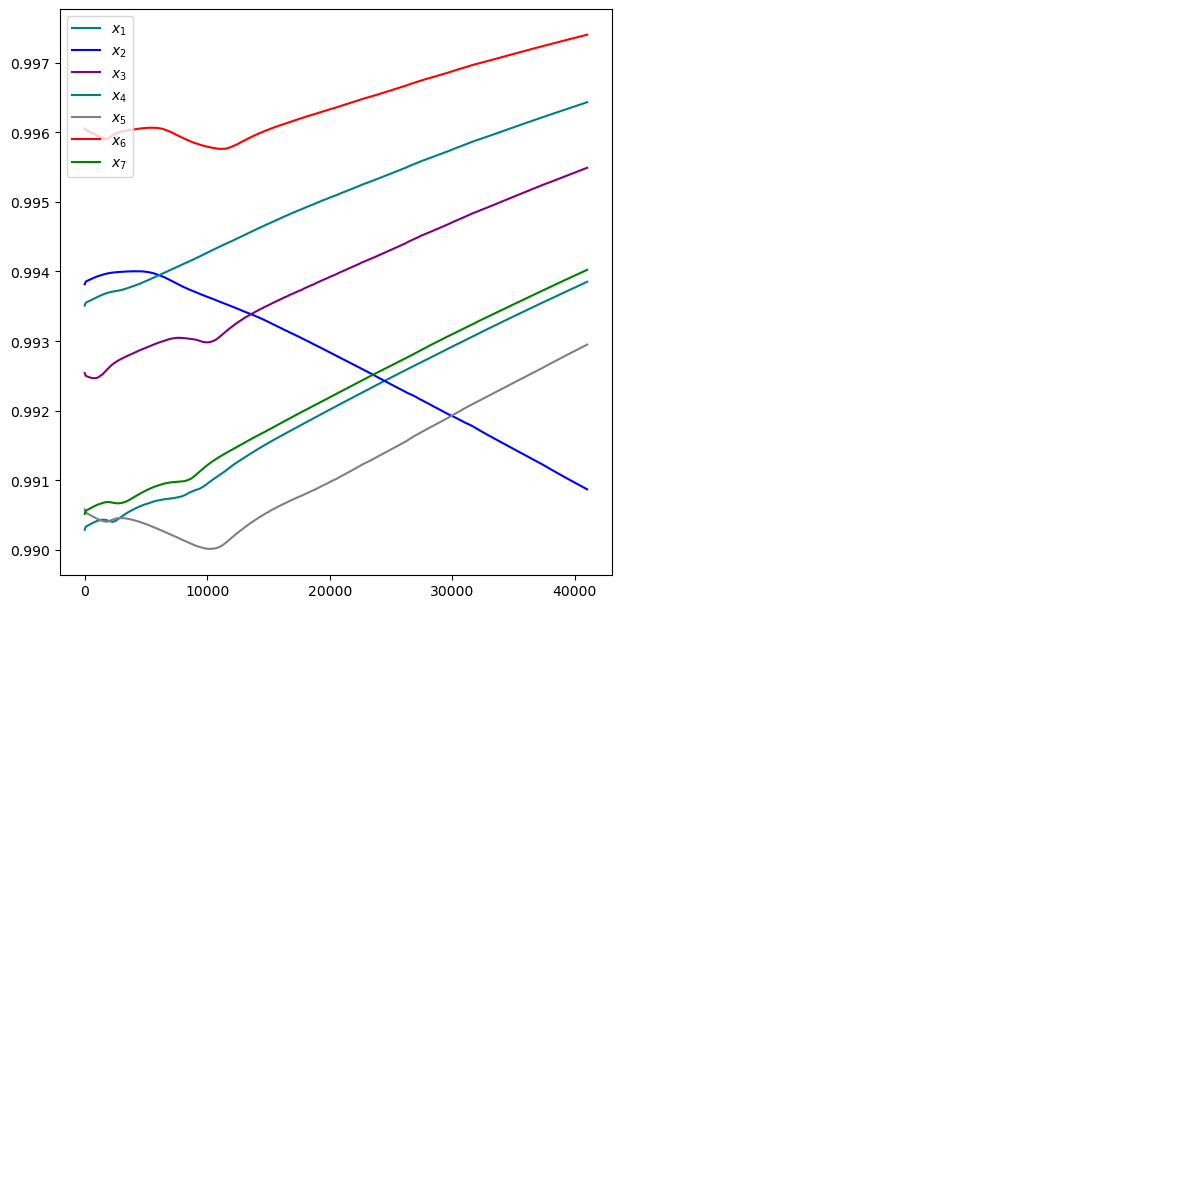

In [14]:
# Create a 2x2 subplot grid
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# Subplot 1
ax[0, 0].plot(np_x1, label='$x_1$', color='teal')
ax[0, 0].plot(np_x2, label='$x_2$', color='blue')
ax[0, 0].plot(np_x3, label='$x_3$', color='purple')
ax[0, 0].plot(np_x4, label='$x_4$', color='teal')
ax[0, 0].plot(np_x5, label='$x_5$', color='grey')
ax[0, 0].plot(np_x6, label='$x_6$', color='red')
ax[0, 0].plot(np_x7, label='$x_7$', color='green')


ax[0, 0].legend()
#ax[0, 0].set_title('Subplot 1: np_q1')

# Subplot 2
#ax[0, 1].plot(np_delta_h, label='$delta_h$', color='orange')
#ax[0, 1].plot(np_delta_v, label='$delta_v$', color='purple')
#ax[0, 1].plot(np_lambd_h, label='$lambd_h$', color='teal')
#ax[0, 1].plot(np_lambd_v, label='$lambd_v$', color='blue')
#ax[0, 1].plot(np_tita, label='$tita$', color='red')

#ax[0, 1].legend()

# Subplot 3
#ax[1, 0].plot(np_beta_h, label='$beta_h$', color='orange')
#ax[1, 0].plot(np_beta_v, label='$beta_v$', color='purple')
#ax[1, 0].plot(np_mu_h, label='$mu_h$', color='teal')
#ax[1, 0].plot(np_mu_v, label='$mu_v$', color='blue')
#ax[1, 0].plot(np_sigma, label='$sigma$', color='red')

#ax[1, 0].legend()

#ax[1, 0].set_title('Subplot 3: np_b, np_m, np_nu')

# Subplot 3
#ax[1, 1].plot(np_alpha_h, label='$alpha_h$', color='orange')
#ax[1, 1].plot(np_alpha_v, label='$alpha_v$', color='purple')
#ax[1, 1].plot(np_phi_h, label='$phi_h$', color='teal')
#ax[1, 1].plot(np_phi_v, label='$phi_v$', color='blue')
#ax[1, 1].plot(np_rho, label='$rho$', color='red')

#ax[1, 1].legend()
ax[1,1].axis('off')
ax[0,1].axis('off')
ax[1,0].axis('off')



# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [15]:
# history is a list of PyTorch tensors
V1_history = dinn.V1_pred_hist
V2_history = dinn.V2_pred_hist
V3_history = dinn.V3_pred_hist
V4_history = dinn.V4_pred_hist
H1_history = dinn.H1_pred_hist
H2_history = dinn.H2_pred_hist
H3_history = dinn.H3_pred_hist

# Convert each tensor to a NumPy array and then to a list
V1_history_np_list = [tensor.detach().numpy().tolist() for tensor in V1_history]
V2_history_np_list = [tensor.detach().numpy().tolist() for tensor in V2_history]
V3_history_np_list = [tensor.detach().numpy().tolist() for tensor in V3_history]
V4_history_np_list = [tensor.detach().numpy().tolist() for tensor in V4_history]
H1_history_np_list = [tensor.detach().numpy().tolist() for tensor in H1_history]
H2_history_np_list = [tensor.detach().numpy().tolist() for tensor in H2_history]
H3_history_np_list = [tensor.detach().numpy().tolist() for tensor in H3_history]



# Create a DataFrame from the list of lists
df_V1 = pd.DataFrame(V1_history_np_list)
df_V2 = pd.DataFrame(V2_history_np_list)
df_V3 = pd.DataFrame(V3_history_np_list)
df_V4 = pd.DataFrame(V4_history_np_list)
df_H1 = pd.DataFrame(H1_history_np_list)
df_H2 = pd.DataFrame(H2_history_np_list)
df_H3 = pd.DataFrame(H3_history_np_list)


# MEANS
V1_pred_mean = np.mean(df_V1, axis=0) 
V2_pred_mean = np.mean(df_V2, axis=0)
V3_pred_mean = np.mean(df_V3, axis=0)
V4_pred_mean = np.mean(df_V4, axis=0) 
H1_pred_mean = np.mean(df_H1, axis=0)
H2_pred_mean = np.mean(df_H2, axis=0)
H3_pred_mean = np.mean(df_H3, axis=0)



V1_pred_std = np.std(df_V1, axis=0) 
V2_pred_std = np.std(df_V2, axis=0) 
V3_pred_std = np.std(df_V3, axis=0)
V4_pred_std = np.std(df_V4, axis=0) 
H1_pred_std = np.std(df_H1, axis=0) 
H2_pred_std = np.std(df_H2, axis=0) 
H3_pred_std = np.std(df_H3, axis=0) 


In [16]:
timesteps_adv=list(range(1,402))
# hist is a list of PyTorch tensors
V1_hist = dinn.V1_adv_hist
V2_hist = dinn.V2_adv_hist
V3_hist = dinn.V3_adv_hist
V4_hist = dinn.V4_adv_hist
H1_hist = dinn.H1_adv_hist
H2_hist = dinn.H2_adv_hist
H3_hist = dinn.H3_adv_hist


# Convert each tensor to a NumPy array and then to a list
V1_hist_np_list = [tensor.detach().numpy().tolist() for tensor in V1_hist]
V2_hist_np_list = [tensor.detach().numpy().tolist() for tensor in V2_hist]
V3_hist_np_list = [tensor.detach().numpy().tolist() for tensor in V3_hist]
V4_hist_np_list = [tensor.detach().numpy().tolist() for tensor in V4_hist]
H1_hist_np_list = [tensor.detach().numpy().tolist() for tensor in H1_hist]
H2_hist_np_list = [tensor.detach().numpy().tolist() for tensor in H2_hist]
H3_hist_np_list = [tensor.detach().numpy().tolist() for tensor in H3_hist]



# Create a DataFrame from the list of lists
df_V1 = pd.DataFrame(V1_hist_np_list)
df_V2 = pd.DataFrame(V2_hist_np_list)
df_V3 = pd.DataFrame(V3_hist_np_list)
df_V4 = pd.DataFrame(V4_hist_np_list)
df_H1 = pd.DataFrame(H1_hist_np_list)
df_H2 = pd.DataFrame(H2_hist_np_list)
df_H3 = pd.DataFrame(H3_hist_np_list)


# MEANS
V1_adv_mean = np.mean(df_V1, axis=0) 
V2_adv_mean = np.mean(df_V2, axis=0)
V3_adv_mean = np.mean(df_V3, axis=0)
V4_adv_mean = np.mean(df_V4, axis=0) 
H1_adv_mean = np.mean(df_H1, axis=0)
H2_adv_mean = np.mean(df_H2, axis=0)
H3_adv_mean = np.mean(df_H3, axis=0)


V1_adv_std = np.std(df_V1, axis=0) 
V2_adv_std = np.std(df_V2, axis=0) 
V3_adv_std = np.std(df_V3, axis=0) 
V4_adv_std = np.std(df_V4, axis=0) 
H1_adv_std = np.std(df_H1, axis=0) 
H2_adv_std = np.std(df_H2, axis=0)
H3_adv_std = np.std(df_H3, axis=0) 




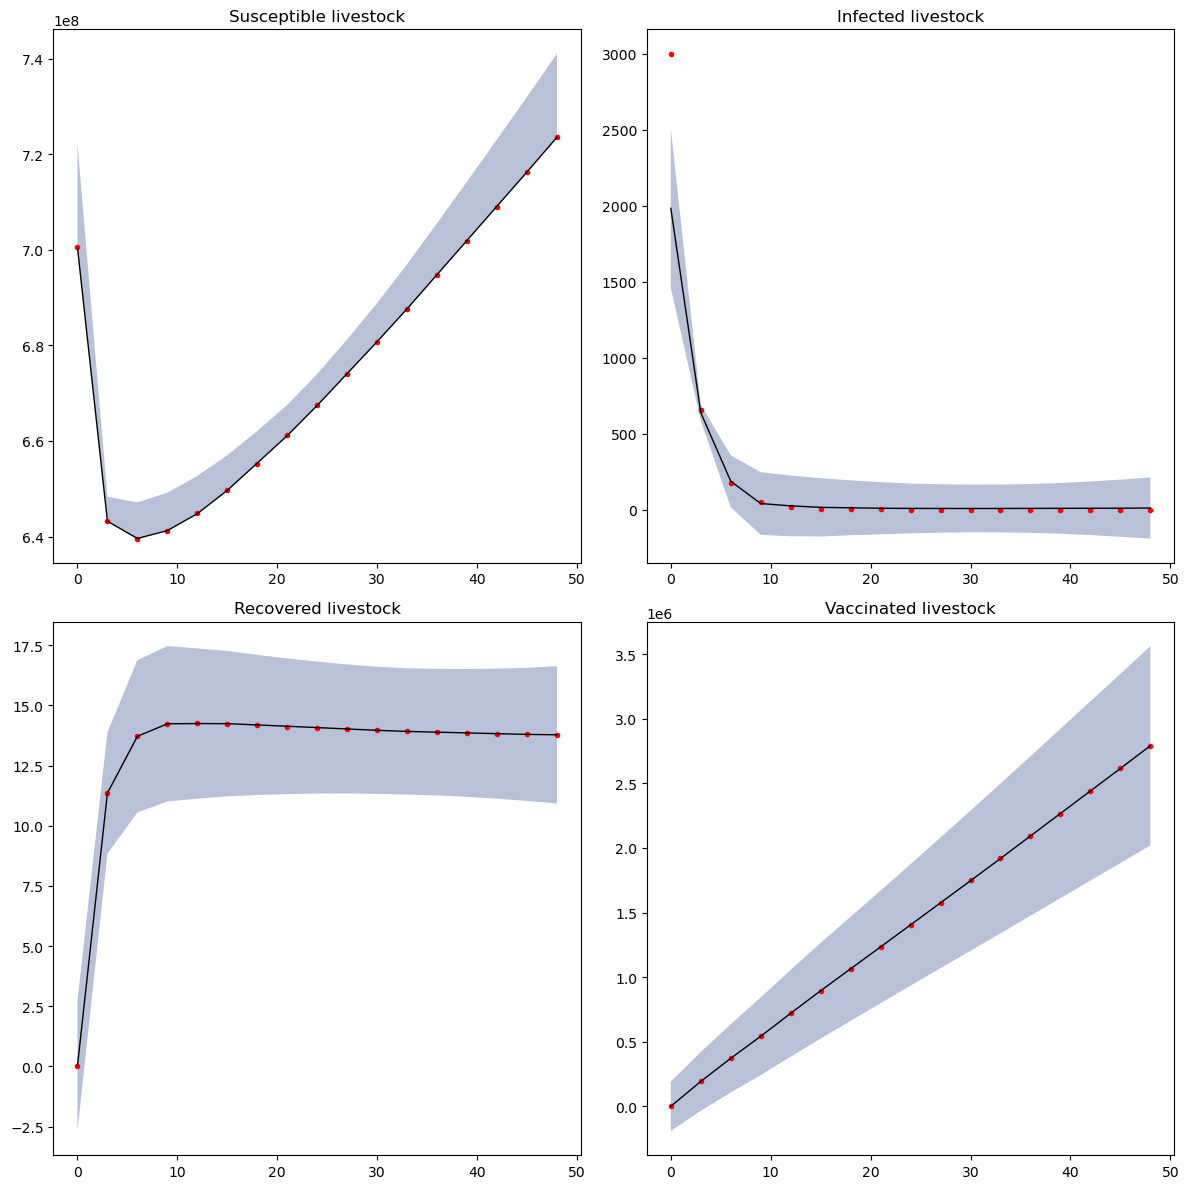

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot V1
axs[0, 0].plot(timesteps, V1_dat, 'ro', lw=1, markersize=3)
axs[0, 0].plot(timesteps, V1_pred_list[0].detach().numpy(), 'k-', lw=1)
axs[0, 0].fill_between(timesteps, \
                       (V1_pred_list[0].detach().numpy() + V1_pred_std), \
                       (V1_pred_list[0].detach().numpy() - V2_pred_std), \
                       facecolor=(0.1, 0.2, 0.5, 0.3), interpolate=True)
axs[0, 0].set_title('Susceptible livestock')

# Plot V2
axs[0, 1].plot(timesteps, V2_dat, 'ro', lw=1, markersize=3)
axs[0, 1].plot(timesteps, V2_pred_list[0].detach().numpy(), 'k-', lw=1)
axs[0, 1].fill_between(timesteps, \
                       (V2_pred_list[0].detach().numpy() + V2_pred_std), \
                       (V2_pred_list[0].detach().numpy() - V2_pred_std), \
                       facecolor=(0.1, 0.2, 0.5, 0.3), interpolate=True)
axs[0, 1].set_title('Infected livestock')

# Plot V3
axs[1, 0].plot(timesteps, V3_dat, 'ro', lw=1, markersize=3)
axs[1, 0].plot(timesteps, V3_pred_list[0].detach().numpy(), 'k-', lw=1)
axs[1, 0].fill_between(timesteps, \
                       (V3_pred_list[0].detach().numpy() + V3_pred_std), \
                       (V3_pred_list[0].detach().numpy() - V3_pred_std), \
                       facecolor=(0.1, 0.2, 0.5, 0.3), interpolate=True)
axs[1, 0].set_title('Recovered livestock')


#plot V4
# Plot V3
axs[1, 1].plot(timesteps, V4_dat, 'ro', lw=1, markersize=3)
axs[1, 1].plot(timesteps, V4_pred_list[0].detach().numpy(), 'k-', lw=1)
axs[1, 1].fill_between(timesteps, \
                       (V4_pred_list[0].detach().numpy() + V4_pred_std), \
                       (V4_pred_list[0].detach().numpy() - V4_pred_std), \
                       facecolor=(0.1, 0.2, 0.5, 0.3), interpolate=True)
axs[1, 1].set_title('Vaccinated livestock')


# Adjust layout
plt.tight_layout()
plt.show()

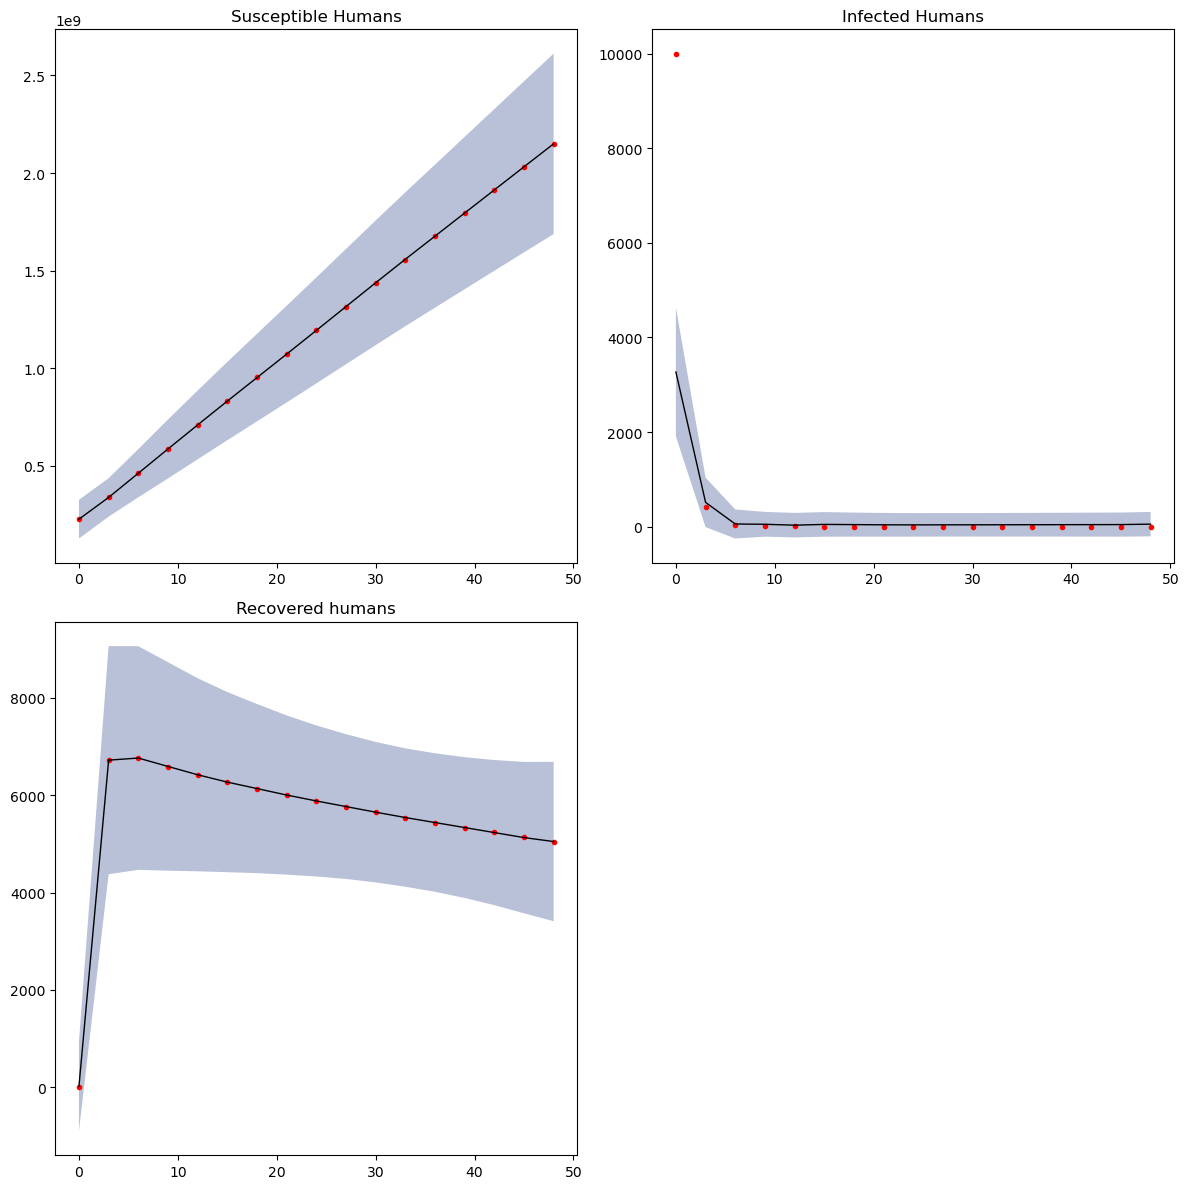

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot V1
axs[0, 0].plot(timesteps, H1_dat, 'ro', lw=1, markersize=3)
axs[0, 0].plot(timesteps, H1_pred_list[0].detach().numpy(), 'k-', lw=1)
axs[0, 0].fill_between(timesteps, \
                       (H1_pred_list[0].detach().numpy() + H1_pred_std), \
                       (H1_pred_list[0].detach().numpy() - H1_pred_std), \
                       facecolor=(0.1, 0.2, 0.5, 0.3), interpolate=True)
axs[0, 0].set_title('Susceptible Humans')

# Plot V2
axs[0, 1].plot(timesteps, H2_dat, 'ro', lw=1, markersize=3)
axs[0, 1].plot(timesteps, H2_pred_list[0].detach().numpy(), 'k-', lw=1)
axs[0, 1].fill_between(timesteps, \
                       (H2_pred_list[0].detach().numpy() + H2_pred_std), \
                       (H2_pred_list[0].detach().numpy() - H2_pred_std), \
                       facecolor=(0.1, 0.2, 0.5, 0.3), interpolate=True)
axs[0, 1].set_title('Infected Humans')

# Plot V3
axs[1, 0].plot(timesteps, H3_dat, 'ro', lw=1, markersize=3)
axs[1, 0].plot(timesteps, H3_pred_list[0].detach().numpy(), 'k-', lw=1)
axs[1, 0].fill_between(timesteps, \
                       (H3_pred_list[0].detach().numpy() + H3_pred_std), \
                       (H3_pred_list[0].detach().numpy() - H3_pred_std), \
                       facecolor=(0.1, 0.2, 0.5, 0.3), interpolate=True)
axs[1, 0].set_title('Recovered humans')

axs[1,1].axis('off')


# Adjust layout
plt.tight_layout()
plt.show()

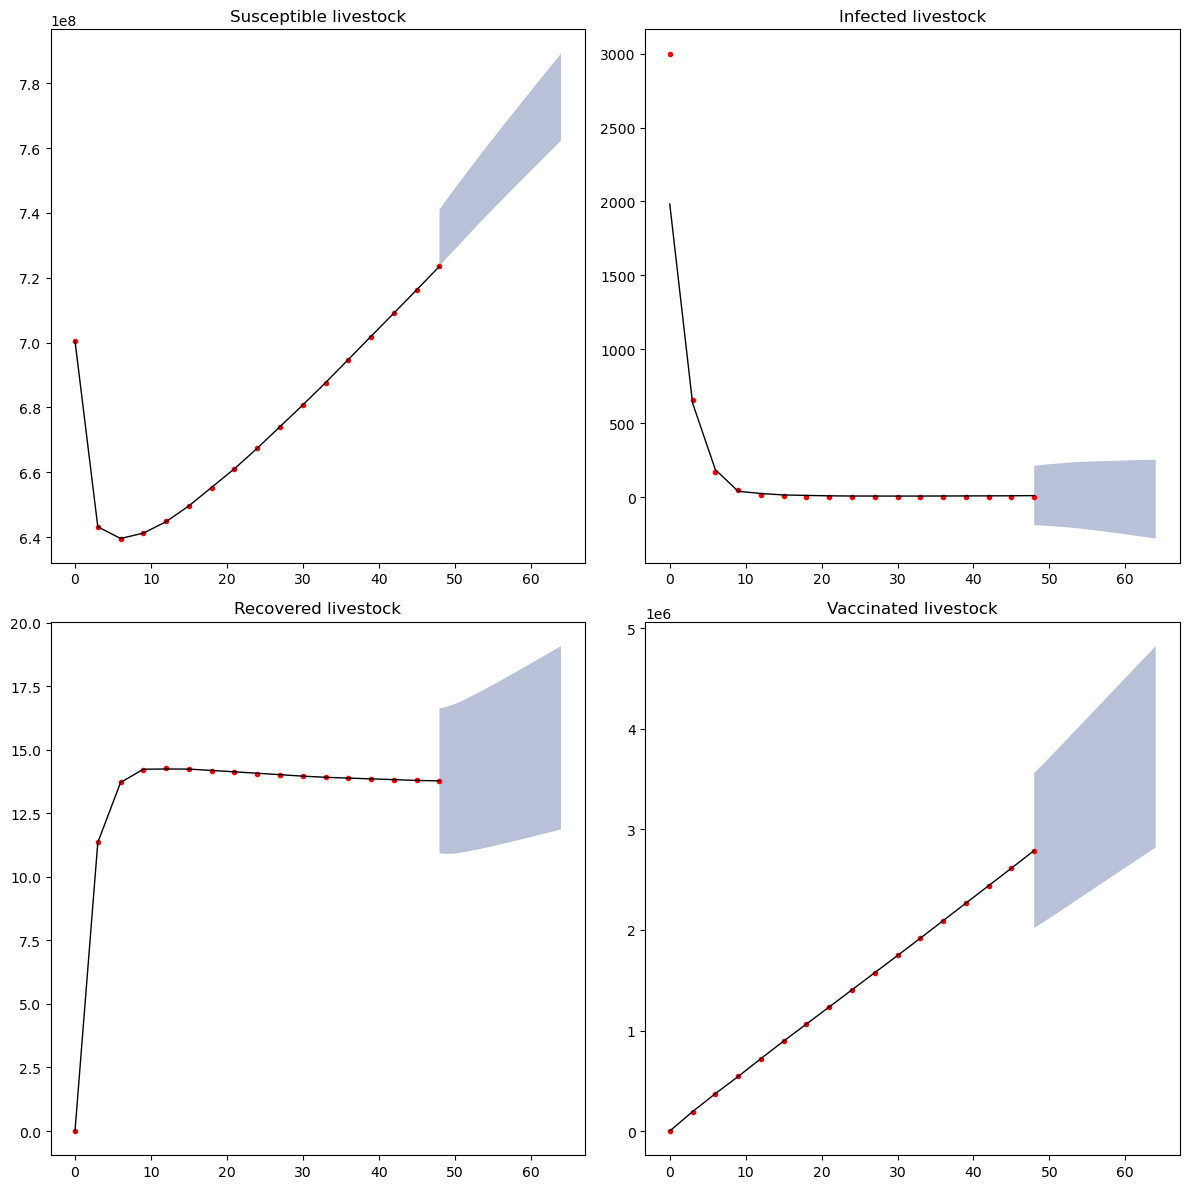

In [19]:
timesteps_adv = list(range(48, 65))
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot V1
axs[0, 0].plot(timesteps, V1_dat, 'ro', lw=1, markersize=3)
axs[0, 0].plot(timesteps, V1_pred_list[0].detach().numpy(), 'k-', lw=1)
axs[0, 0].fill_between(timesteps_adv, \
                       (V1_Adv_list[0].detach().numpy() + V1_adv_std), \
                       (V1_Adv_list[0].detach().numpy() - V2_adv_std), \
                       facecolor=(0.1, 0.2, 0.5, 0.3), interpolate=True)
axs[0, 0].set_title('Susceptible livestock')

# Plot V2
axs[0, 1].plot(timesteps, V2_dat, 'ro', lw=1, markersize=3)
axs[0, 1].plot(timesteps, V2_pred_list[0].detach().numpy(), 'k-', lw=1)
axs[0, 1].fill_between(timesteps_adv, \
                       (V2_Adv_list[0].detach().numpy() + V2_adv_std), \
                       (V2_Adv_list[0].detach().numpy() - V2_adv_std), \
                       facecolor=(0.1, 0.2, 0.5, 0.3), interpolate=True)
axs[0, 1].set_title('Infected livestock')

# Plot V3
axs[1, 0].plot(timesteps, V3_dat, 'ro', lw=1, markersize=3)
axs[1, 0].plot(timesteps, V3_pred_list[0].detach().numpy(), 'k-', lw=1)
axs[1, 0].fill_between(timesteps_adv, \
                       (V3_Adv_list[0].detach().numpy() + V3_adv_std), \
                       (V3_Adv_list[0].detach().numpy() - V3_adv_std), \
                       facecolor=(0.1, 0.2, 0.5, 0.3), interpolate=True)
axs[1, 0].set_title('Recovered livestock')


#plot V4
# Plot V3
axs[1, 1].plot(timesteps, V4_dat, 'ro', lw=1, markersize=3)
axs[1, 1].plot(timesteps, V4_pred_list[0].detach().numpy(), 'k-', lw=1)
axs[1, 1].fill_between(timesteps_adv, \
                       (V4_Adv_list[0].detach().numpy() + V4_adv_std), \
                       (V4_Adv_list[0].detach().numpy() - V4_adv_std), \
                       facecolor=(0.1, 0.2, 0.5, 0.3), interpolate=True)
axs[1, 1].set_title('Vaccinated livestock')


# Adjust layout
plt.tight_layout()
plt.show()

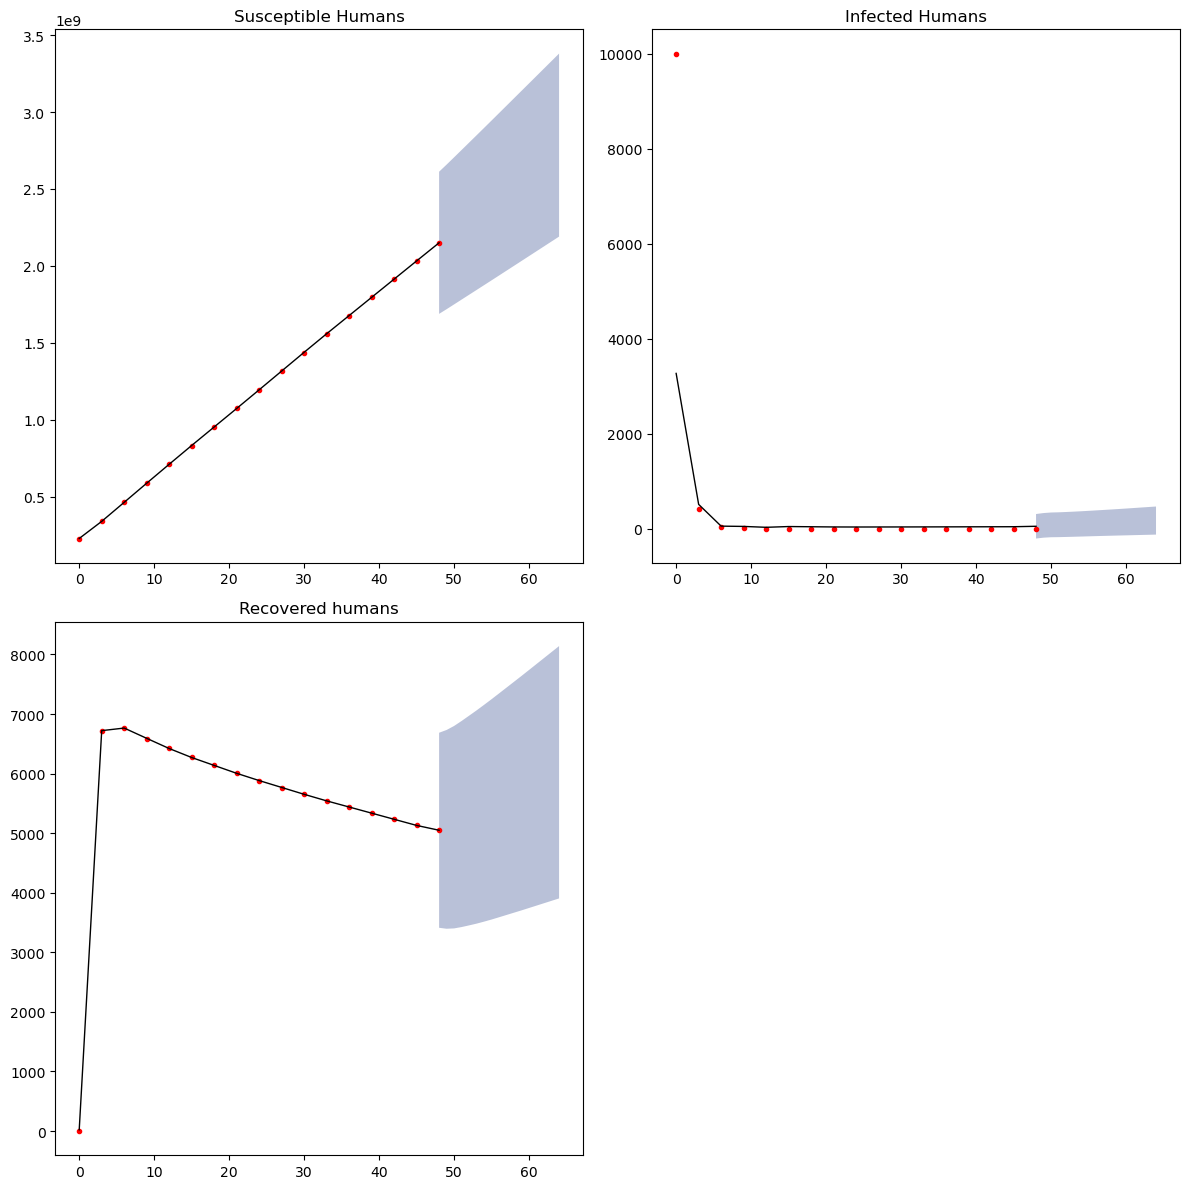

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot V1
axs[0, 0].plot(timesteps, H1_dat, 'ro', lw=1, markersize=3)
axs[0, 0].plot(timesteps, H1_pred_list[0].detach().numpy(), 'k-', lw=1)
axs[0, 0].fill_between(timesteps_adv, \
                       (H1_Adv_list[0].detach().numpy() + H1_adv_std), \
                       (H1_Adv_list[0].detach().numpy() - H1_adv_std), \
                       facecolor=(0.1, 0.2, 0.5, 0.3), interpolate=True)
axs[0, 0].set_title('Susceptible Humans')

# Plot V2
axs[0, 1].plot(timesteps, H2_dat, 'ro', lw=1, markersize=3)
axs[0, 1].plot(timesteps, H2_pred_list[0].detach().numpy(), 'k-', lw=1)
axs[0, 1].fill_between(timesteps_adv, \
                       (H2_Adv_list[0].detach().numpy() + H2_adv_std), \
                       (H2_Adv_list[0].detach().numpy() - H2_adv_std), \
                       facecolor=(0.1, 0.2, 0.5, 0.3), interpolate=True)
axs[0, 1].set_title('Infected Humans')

# Plot V3
axs[1, 0].plot(timesteps, H3_dat, 'ro', lw=1, markersize=3)
axs[1, 0].plot(timesteps, H3_pred_list[0].detach().numpy(), 'k-', lw=1)
axs[1, 0].fill_between(timesteps_adv, \
                       (H3_Adv_list[0].detach().numpy() + H3_adv_std), \
                       (H3_Adv_list[0].detach().numpy() - H3_adv_std), \
                       facecolor=(0.1, 0.2, 0.5, 0.3), interpolate=True)
axs[1, 0].set_title('Recovered humans')

axs[1,1].axis('off')


# Adjust layout
plt.tight_layout()
plt.show()

In [21]:
#Accuracy Analysis

def mean_absolute_error(y_true, y_pred):
    n = len(y_true)
    mae = np.sum(np.abs(y_pred - y_true)) / n
    return mae

# Root Mean Squared Error (RMSE)
def root_mean_squared_error(y_true, y_pred):
    n = len(y_true)
    rmse = np.sqrt(np.sum((y_pred - y_true) ** 2) / n)
    return rmse

# Coefficient of Determination (R^2)
def r_squared(y_true, y_pred):
    u_res = np.sum((y_true - y_pred) ** 2)
    u_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (u_res / u_tot)
    return r2

In [22]:
# For variable H1
mae_H1 = mean_absolute_error(H1_dat, H1_pred_list[0].detach().numpy())
rmse_H1 = root_mean_squared_error(H1_dat, H1_pred_list[0].detach().numpy())
r2_H1 = r_squared(H1_dat, H1_pred_list[0].detach().numpy())

# For variable H2
mae_H2 = mean_absolute_error(H2_dat, H2_pred_list[0].detach().numpy())
rmse_H2 = root_mean_squared_error(H2_dat, H2_pred_list[0].detach().numpy())
r2_H2 = r_squared(H2_dat, H2_pred_list[0].detach().numpy())

# For variable H3
mae_H3 = mean_absolute_error(H3_dat, H3_pred_list[0].detach().numpy())
rmse_H3 = root_mean_squared_error(H3_dat, H3_pred_list[0].detach().numpy())
r2_H3 = r_squared(H3_dat, H3_pred_list[0].detach().numpy())

# For variable V1
mae_V1 = mean_absolute_error(V1_dat, V1_pred_list[0].detach().numpy())
rmse_V1 = root_mean_squared_error(V1_dat, V1_pred_list[0].detach().numpy())
r2_V1 = r_squared(V1_dat, V1_pred_list[0].detach().numpy())

# For variable V2
mae_V2 = mean_absolute_error(V2_dat, V2_pred_list[0].detach().numpy())
rmse_V2 = root_mean_squared_error(V2_dat, V2_pred_list[0].detach().numpy())
r2_V2 = r_squared(V2_dat, V2_pred_list[0].detach().numpy())

# For variable V3
mae_V3 = mean_absolute_error(V3_dat, V3_pred_list[0].detach().numpy())
rmse_V3 = root_mean_squared_error(V3_dat, V3_pred_list[0].detach().numpy())
r2_V3 = r_squared(V3_dat, V3_pred_list[0].detach().numpy())

# For variable V4
mae_V4 = mean_absolute_error(V4_dat, V4_pred_list[0].detach().numpy())
rmse_V4 = root_mean_squared_error(V4_dat, V4_pred_list[0].detach().numpy())
r2_V4 = r_squared(V4_dat, V4_pred_list[0].detach().numpy())







In [23]:
 #Create a dictionary with the results
results_dict = {
    'Variable': ['H1','H2', 'H3', 'V1','V2','V3','V4'],
    'MAE': [mae_H1, mae_H2, mae_H3, mae_V1, mae_V2, mae_V3, mae_V4],
    'RMSE': [rmse_H1, rmse_H2, rmse_H3, rmse_V1, rmse_V2, rmse_V3, rmse_V4],
    'R2': [r2_H1, r2_H2, r2_H3, r2_V1, r2_V2, r2_V3, r2_V4]}

# Create a panda DataFrame from the dictionary
results_df = pd.DataFrame(results_dict)

# Display the DataFrame
print(results_df)

  Variable            MAE          RMSE        R2
0       H1  860435.198160  1.095160e+06  0.999997
1       H2     435.422856  1.632949e+03  0.516322
2       H3       3.630468  5.954185e+00  0.999984
3       V1   64453.642824  7.641015e+04  0.999992
4       V2      68.856648  2.469425e+02  0.878923
5       V3       0.008947  1.220064e-02  0.999986
6       V4    1174.344778  1.641727e+03  0.999996
